# Прогнозы и предсказания

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.  

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Наша задача — провести анализ и подготовить план действий по удержанию клиентов. А именно:  
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток.

В нашем распоряжении **набор данных**, которы включают в себя следующие поля:

Churn — факт оттока в текущем месяце;

**Данные клиента за предыдущий до проверки факта оттока месяц:** 

gender — пол;    
Near_Location — проживание или работа в районе, где находится фитнес-центр;  
Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
Phone — наличие контактного телефона;  
Age — возраст;  
Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).  

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);  
Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);  
Group_visits — факт посещения групповых занятий;  
Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;  
Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;  
Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.  

Исходя из вышесказанного разделим данное исследование на несколько частей.

[Часть 1. Загрузка данных](#1.)  
[Часть 2. Исследовательский анализ данных](#2.)  
[Часть 3. Модель прогнозирования оттока клиентов](#3.)  
* [3.1. Логистическая регрессия](#3.1.)
* [3.2. Случайный лес ](#3.2.) 

[Часть 4. Кластеризация клиентов](#4.)  

В завершении сформулируем [основные выводы и дадим базовые рекомендации](#5.) по повышению качества работы с клиентами:
* выделить целевые группы клиентов;
* предложить меры по снижению оттока;
* определить другие особенности взаимодействия с клиентами.

### Часть 1. Загрузка данных <a id='1.'></a> 

Импортируем необходимые для проведения исследования библиотеки и загрузим подготовленные заказчиком данные, которые содержат информацию на месяц до оттока и факт оттока на определённый месяц.

In [1]:
# Импортурем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Считаем csv файл 
gym_churn = pd.read_csv('/datasets/gym_churn.csv')

# Выведем 5 случайных строк
gym_churn.sample(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3594,0,1,1,1,0,6,1,31,8.256842,5.0,1,1.154416,1.027208,0
3186,1,1,0,0,1,1,0,25,108.829617,1.0,0,0.357429,0.010516,1
259,1,1,1,1,1,6,1,30,9.791782,6.0,2,2.844361,2.969157,0
1716,0,1,0,0,1,12,1,26,255.740266,12.0,7,3.236632,3.106719,0
170,0,1,1,0,1,1,1,29,299.264752,1.0,4,2.170287,1.984470,0


In [3]:
# Выведем общую информацию о датафрейме
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [4]:
# Проверим датафрейм на наличие дубликатов
print('Количество дубликатов в исходных данных:', gym_churn.duplicated().sum())

Количество дубликатов в исходных данных: 0


Каждая строка предоставленных данных содержит информацию по конкретному клиенту сети фитнес-центров, при этом эти сведения не включают в себя пропуски или дубликаты.   

На что сразу было обращено внимание - в названиях столбцов присутствует разный регистр букв - приведем все признаки к единому регистру. И срок до окончания текущего действующего абонемента (Month_to_end_contract) измеряется в месяцах - изменим тип данных с дробного на целочисленный. 

In [5]:
# Приведем названия столбцов к нижнему регистру
gym_churn.columns = gym_churn.columns.str.lower()

# Выведем названия столбцов после преобразования
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [6]:
# Приведем значения 'month_to_end_contract' к целочисленному типу
gym_churn['month_to_end_contract'] = gym_churn['month_to_end_contract'].astype(int)

# Проверим тип данных после преобразования
gym_churn['month_to_end_contract'].dtypes

dtype('int64')

### Часть 2. Исследовательский анализ данных <a id='2.'></a>

Посмотрим на данные более детально и для начала рассмотрим все количественные признаки, изучим средние значения и стандартные отклонения.

In [7]:
# Рассмотрим характеристики количественных признаков
gym_churn.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Все признаки наших исходных данных - количественные (числовые). По ним мы можем сделать следующие выводы:  
* доля мужчин и доля женщин среди клиентов сети фитнес-центров примерно одинаковая - составляет около 50%;  
* почти 85% клиентов выбирают фитнес-центры вблизи своей работы или района проживания;  
* почти половина всех клиентов являются сотрудниками компании-партнёра клуба;  
* на долю чуть более 30% приходятся клиенты, которые использовали промо-код от знакомого при оплате первого абонемента;  
* более 90% клиентов оставляют фитнес-центрам контактные номера для связи; 
* средняя длительность текущего действующего абонемента - почти 5 месяцев. Однако, чаще остальных встречается значение - 1 месяц;
* на показатель посещения групповых занятий приходится - чуть более 40%;
* средний и самый распространенный возраст клиентов - 29 лет;  
* средняя суммарная выручка с продажи доп. услуг с каждого клиента фитнес-центров - почти 150 единиц;
* средний срок до окончания текущего действующего абонемента - чуть меньше 5 месяцев, хотя 1 месяц - наиболее часто встречающееся значение;
* как правило, наши клиенты остаются с нами в течение 3 месяцев с момента первого обращения;  
* средняя частота посещений в неделю за все время с начала действия абонемента - 1.9; 
* средняя частота посещений в неделю за предыдущий месяц - 1.8;
* в среднем в текущем месяце заказчик потерял 26.5% клиентов.

В случаях, где стандартное отклонение значительно отличается от среднего - мы можем говорить о большой вариабельности данных. Например, в случае с суммарной выручкой от других услуг фитнес-центра мы можем наблюдать большой разброс значений.

Далее посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [8]:
# Сгруппируем данные по средним значениям столбца 'churn'
gym_churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


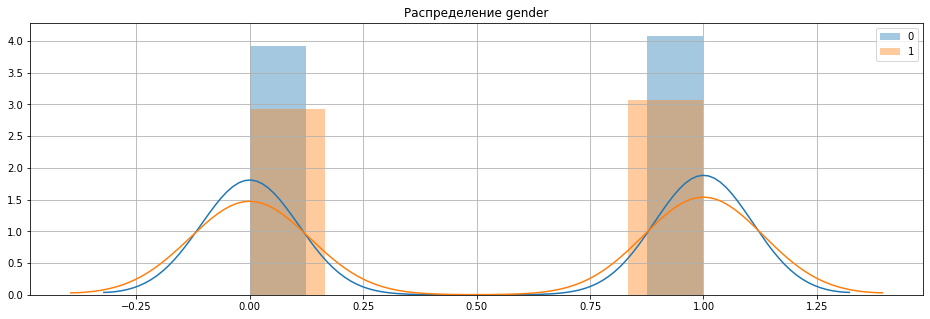

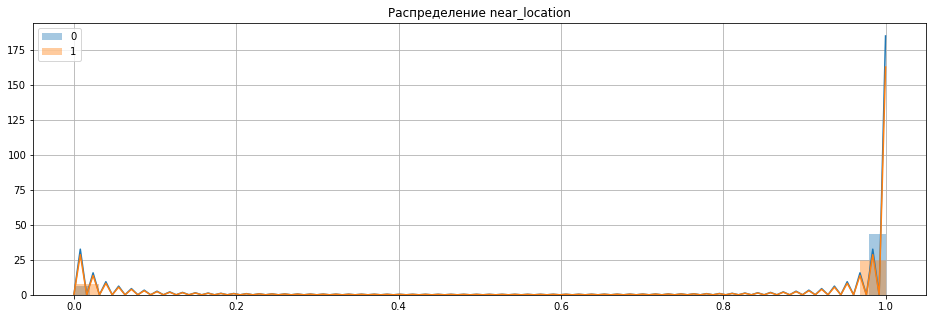

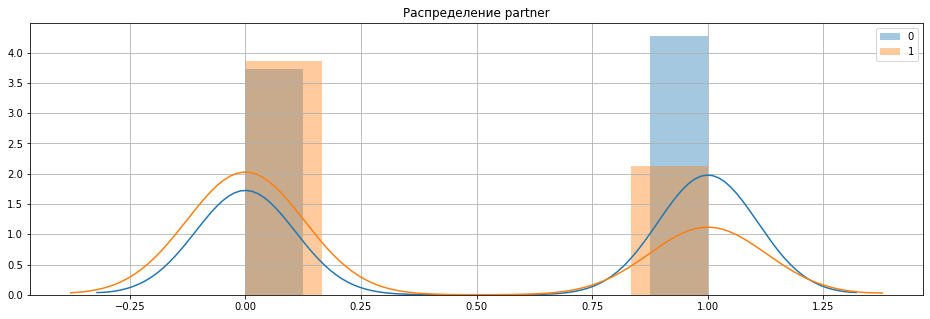

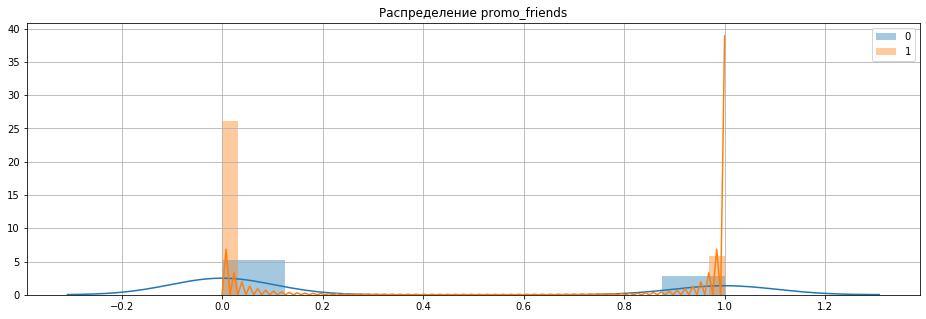

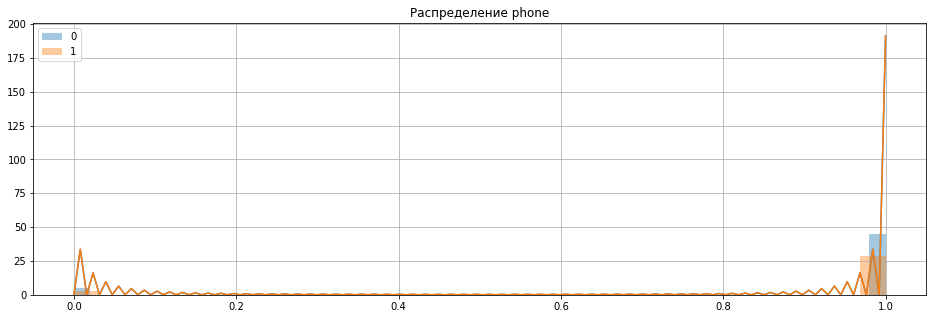

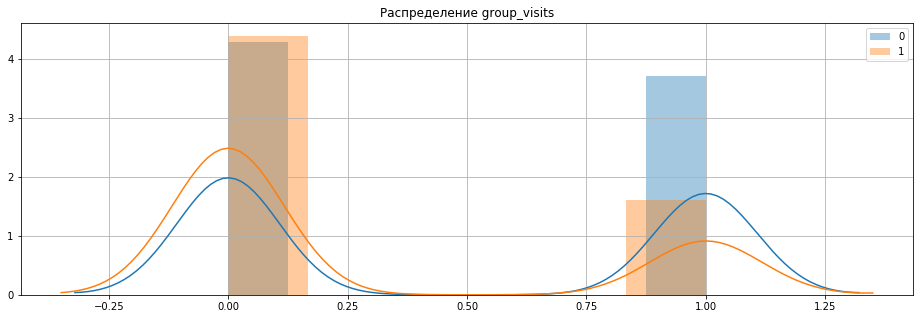

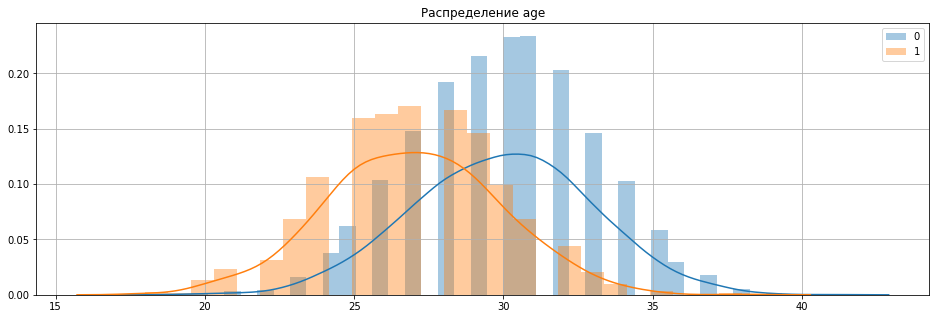

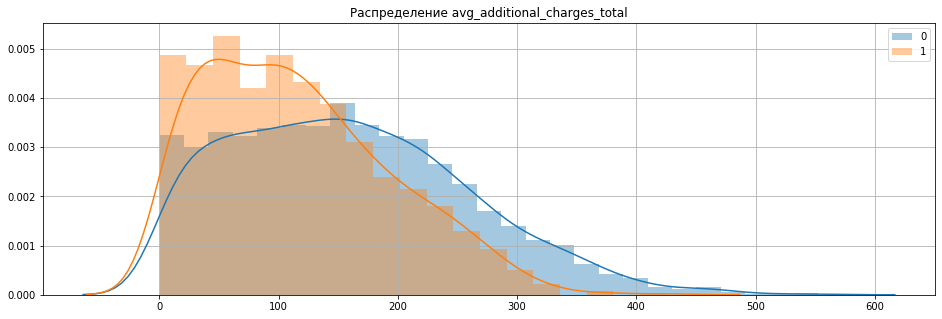

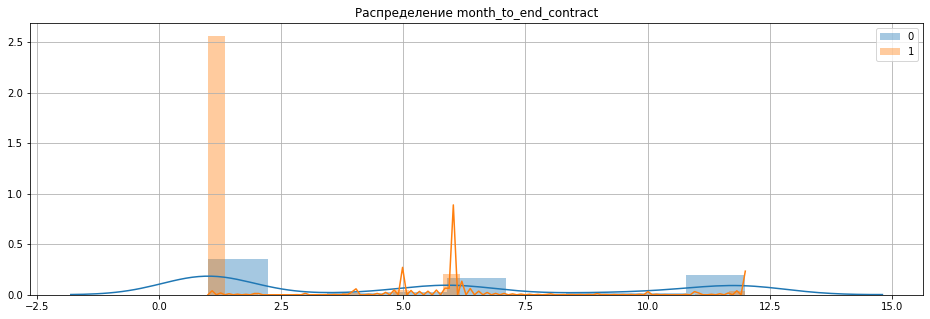

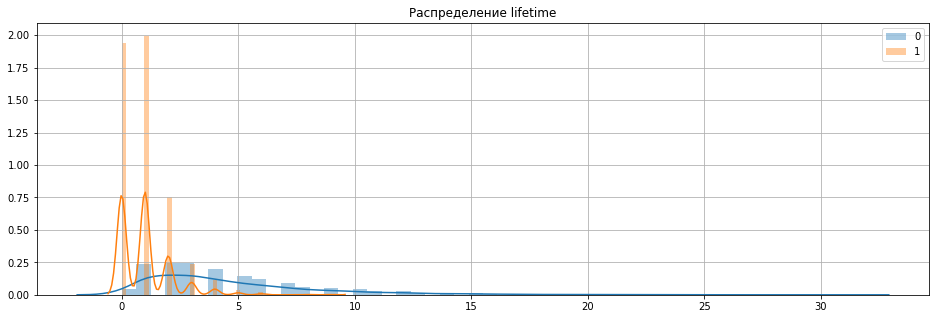

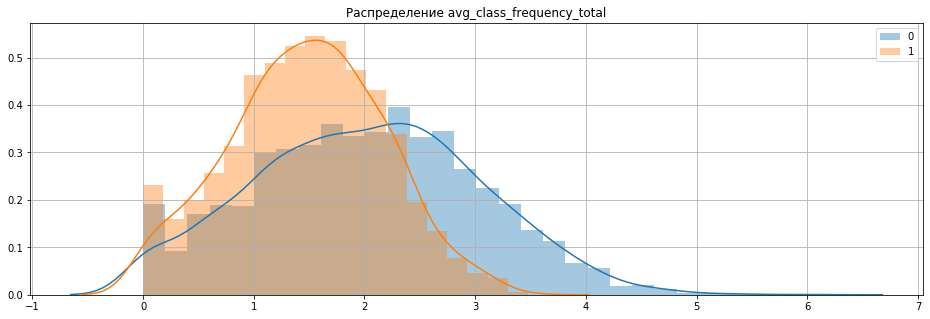

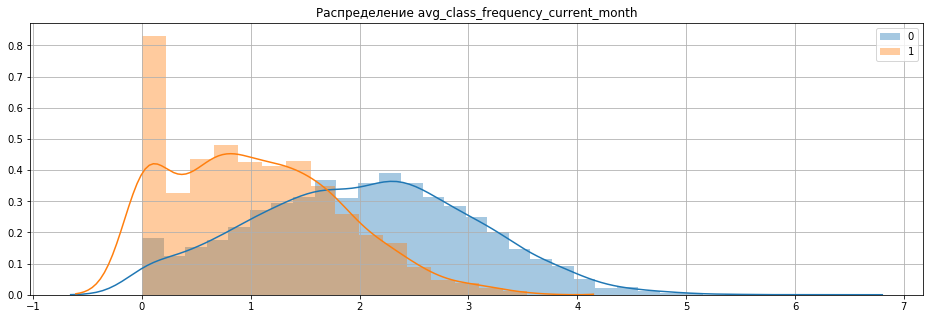

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


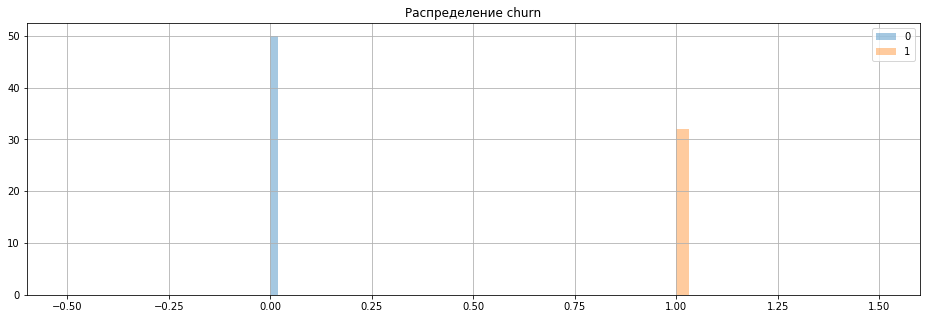

In [9]:
# Построим столбчатые гистограммы
for col in gym_churn.loc[:, gym_churn.columns != 'contract_period'].columns:
    plt.figure(figsize=(16,5))
    plt.grid()
    for churn in gym_churn['churn'].unique():
        plt.title('Распределение '+col)
        sns.distplot(gym_churn.query('churn == @churn')[col], label=churn)
    plt.xlabel('')
    plt.legend()
    plt.show()

Исходя из полученных значений мы можем обрисовать портрет клиента, который более подвержен попаданию в отток. Это люди, которые не всегда выбирают фитнес-центры поблизости с домом или работой, не всегда являются сотрудниками компаний-партнеров, редко являются участниками акции "Приведи друга", редко посещают групповые программы, тратят меньше средств на приобретение доп. услуг и т.д.   
Иными словами - это те клиенты, которые не так сильно замотивированны на посещение спортзала и срок действия абонементов которых, как правило, - 3 месяца.

Построим матрицу корреляций и изучим зависимости признаков.

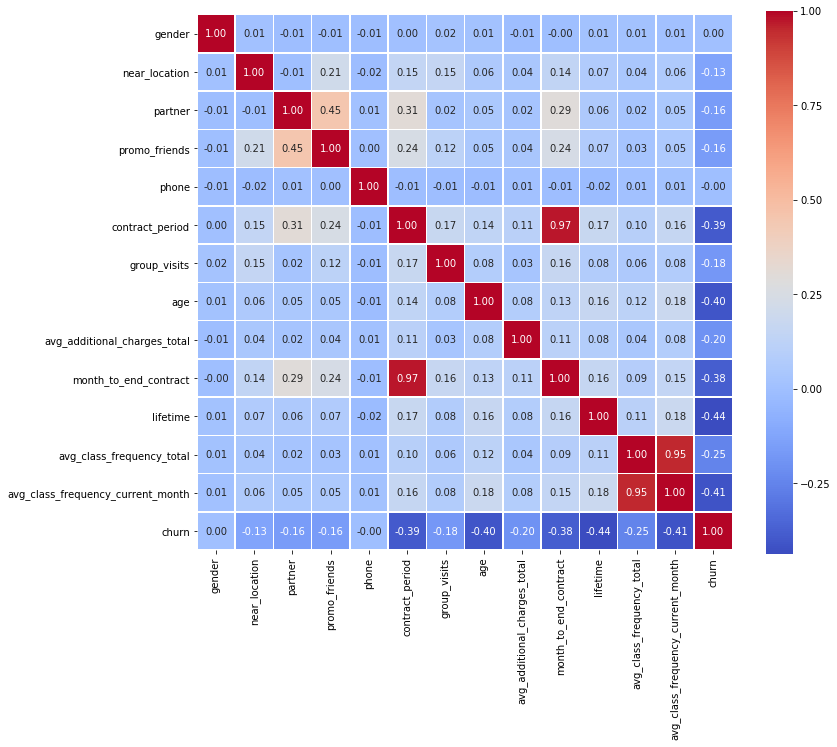

In [10]:
# Построим матрицу корреляций
plt.figure(figsize=(12, 10))
sns.heatmap(gym_churn.corr(), annot = True, fmt='.2f', square=True, cmap='coolwarm', linewidths=.5, linecolor='white')
plt.show()

Самая сильная корреляция наблюдается:
* между длительностью текущего действующего абонемента ('Contract_period') и сроком до его окончания ('Month_to_end_contract');
* между средней частотой посещений в неделю за все время с начала действия абонемента ('Avg_class_frequency_total') и средней частота посещений в неделю за предыдущий месяц ('Avg_class_frequency_current_month').  

Совсем не коррелируют с целевой переменой: пол ('gender') и номер телефона клиента ('Phone'). 

### Часть 3. Модель прогнозирования оттока клиентов <a id='3.'></a>

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. И начнем с разбиения данных на обучающую и валидационную выборки.

In [11]:
# Разделим исходные данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop(['churn'], axis=1)
y = gym_churn['churn'] 
 
# Разделим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=0)

Обучим модель на train-выборке двумя способами: логистической регрессией, случайным лесом.

#### 3.1. Логистическая регрессия <a id='3.1.'></a>

In [12]:
# Зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear')

# Обучим модель логистической регрессии
lr_model.fit(X_train, y_train)

# Воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test)

# Выведем метрики для полученного прогноза
print('Метрики для модели логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, lr_predictions)))

Метрики для модели логистической регрессии:
Accuracy: 0.93
Precision: 0.89
Recall: 0.84


#### 3.2. Случайный лес <a id='3.2.'></a>

In [13]:
# Зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

# Обучим модель случайного леса
rf_model.fit(X_train, y_train)

# Воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test) 

# Выведем метрики для полученного прогноза
print('Метрики для модели случайного леса:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики для модели случайного леса:
Accuracy: 0.92
Precision: 0.88
Recall: 0.83


Доля верно угаданных ответов из всех прогнозов у двух алгоритмов довольна высокая, на нее приходится более 90%. Однако, если оценить модели без привязки к соотношению классов, рассчитав метрики точности и полноты - то здесь ответы разняться и для реализации нашей задачи больше подойдет алгоритм логистической регрессии, т.к. значения его метрик выше.  
Стоит отметить, что в данном случае мы не задавали параметры дерева и использовали все значения по умолчанию. 

### Часть 4.  Кластеризация клиентов <a id='4.'></a>

На данном шаге кластеризуем клиентов, а именно, приведёт значения признаков к виду стандартного нормального распределения. Начнем со стандартизации данных.

In [14]:
# Cтандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(gym_churn.drop(['churn'], axis=1))

Построим матрицу расстояний на стандартизованной матрице признаков и нарисуем дендрограмму.

In [15]:
# Передадим получившуюся стандартизированную таблицу в качестве параметра функции 
linked = linkage(X_sc, method = 'ward') 

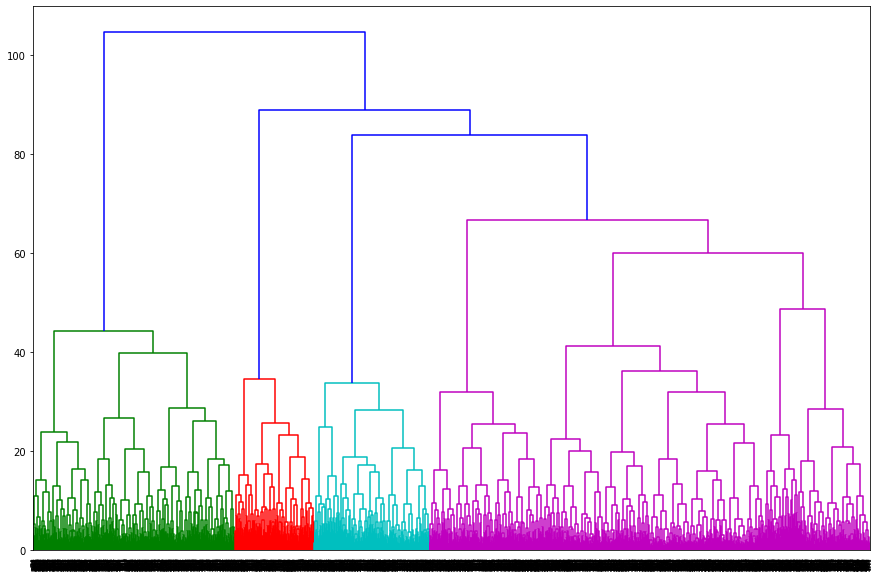

In [16]:
# Визуализируем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Исходя из количества цветов, представленных на графике, будем считать, что наиболее оптимальное количество кластеров - четыре.

После нахождения оптимального числа кластеров запустим теперь более быстрый алгоритм K-Means.

In [17]:
# Зададим число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state=0) 

# Применим алгоритм к данным и сформируем вектор кластеров 
labels = km.fit_predict(X_sc) 

# Сохраним метки кластера в поле наших данных
gym_churn['cluster_km'] = labels

# Выведем статистику по средним значениям наших признаков по кластеру
gym_churn.groupby(['cluster_km']).mean().sort_values(by='churn', ascending=False).transpose()

cluster_km,3,2,1,4,0
gender,0.485737,0.495050,0.522078,0.560335,0.502473
near_location,1.000000,0.000000,0.862338,0.976105,0.959446
partner,0.350238,0.463366,0.470130,0.356033,0.783383
promo_friends,0.240095,0.079208,0.306494,0.229391,0.574679
phone,1.000000,1.000000,0.000000,0.998805,1.000000
contract_period,1.948494,2.352475,4.787013,2.665472,10.884273
group_visits,0.341521,0.215842,0.425974,0.473118,0.543027
age,28.167987,28.477228,29.301299,30.127838,29.980218
avg_additional_charges_total,131.622204,135.457501,143.957664,161.724258,160.706969
month_to_end_contract,1.856577,2.198020,4.475325,2.455197,9.950544


Анализируя эти данные, можем проследить долю оттока клиентов в каждом из классов и какие конкретно признаки оказывают на это наибольшее влияние. Например, средние значения возраста в каждом из классов примерно одинаковы, а значит данный показатель не оказывает существенного влияния на отток. Однако, в каждом из кластеров есть такие признаки, которые все же влияют на срок взаимодействия клиента с нами. Рассмотрим их более подробно на графиках распределения. 

In [18]:
# Зададим переменные для дискретных и непрерывных параметров
discrete_variable = ['gender', 'near_location', 'partner', 'promo_friends',\
                     'phone', 'contract_period', 'group_visits','churn']

сontinuous_variable = ['age', 'avg_additional_charges_total', 'month_to_end_contract',\
                       'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

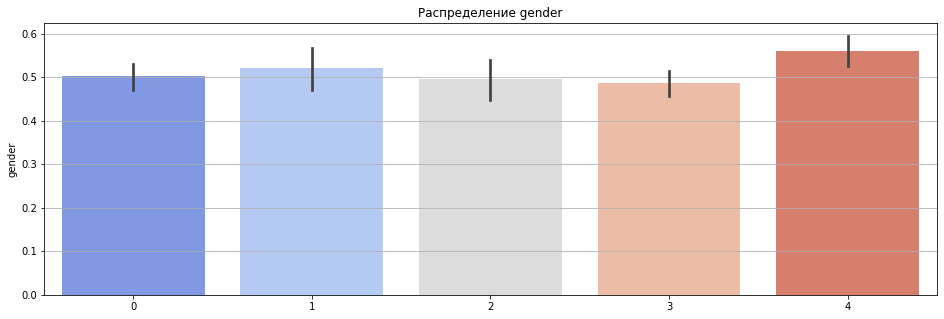

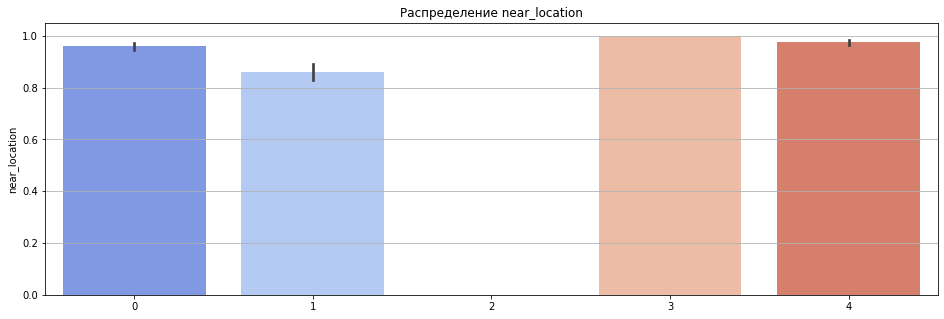

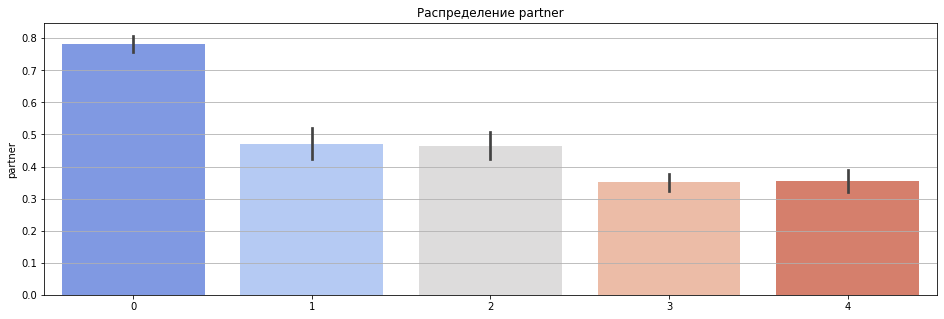

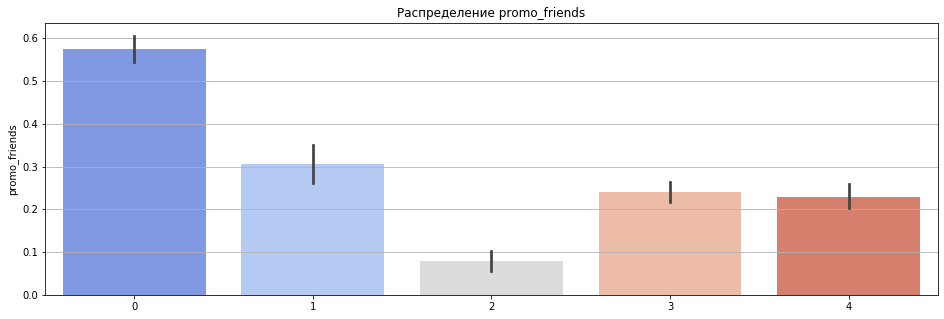

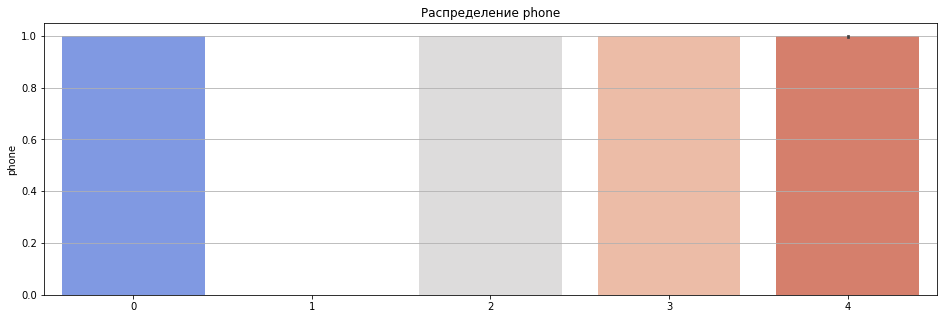

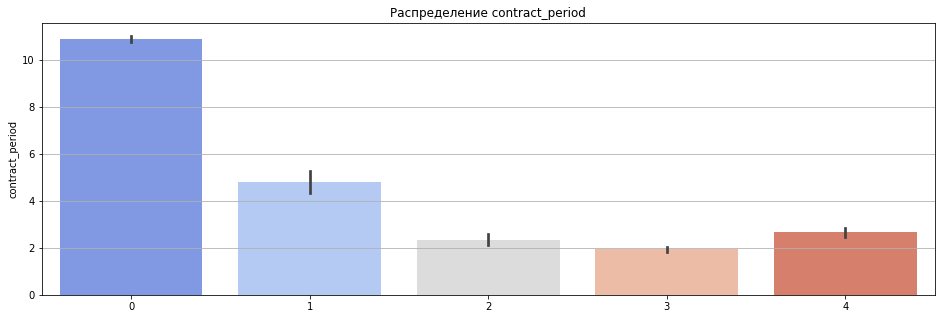

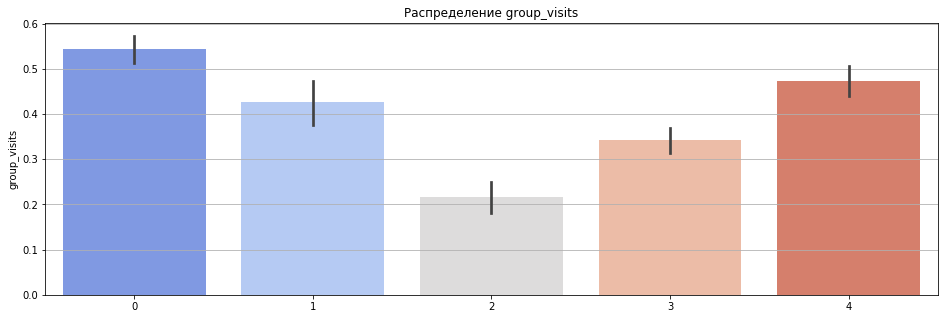

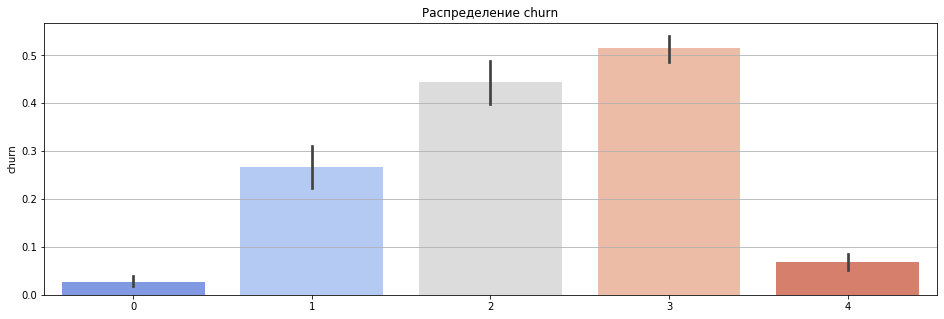

In [19]:
# Построим диаграммы для дискретных переменных
for column in discrete_variable:
    plt.figure(figsize=(16,5))
    plt.grid()
    sns.barplot(x='cluster_km', y=column, data=gym_churn, palette = 'coolwarm')  
    plt.title('Распределение ' + column)
    plt.xlabel('')
    plt.show()

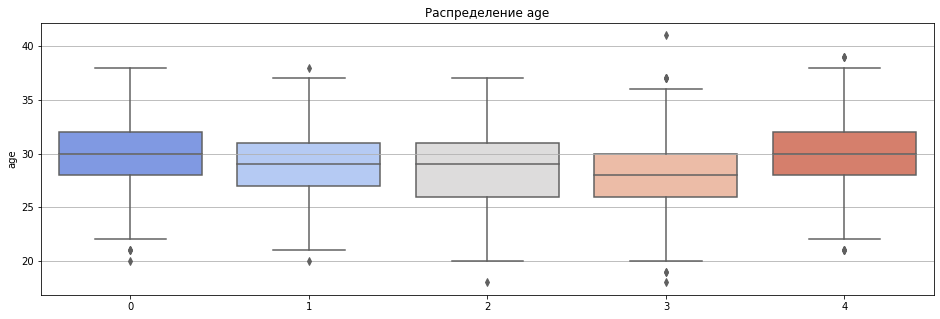

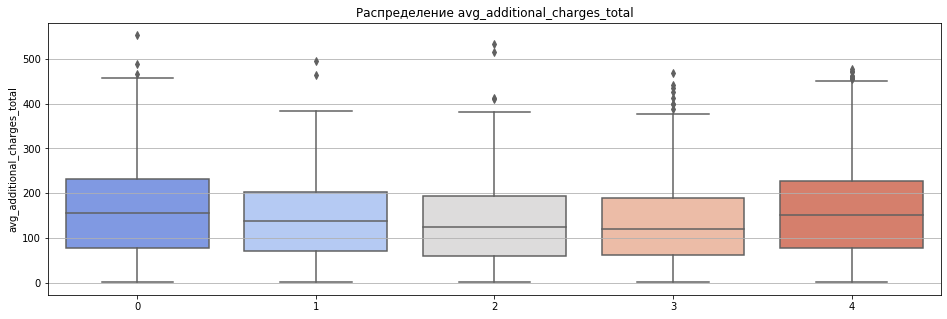

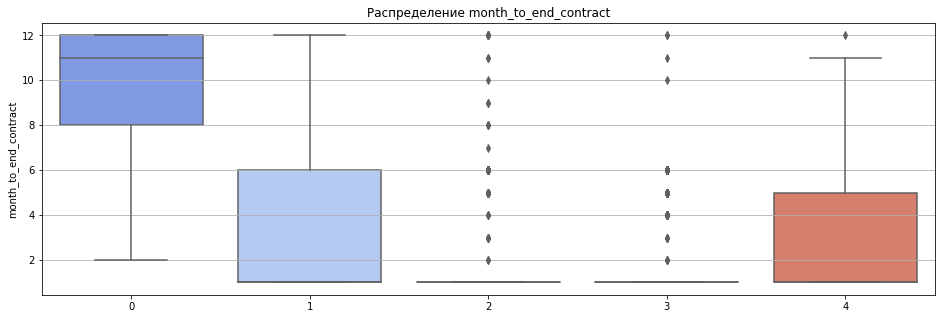

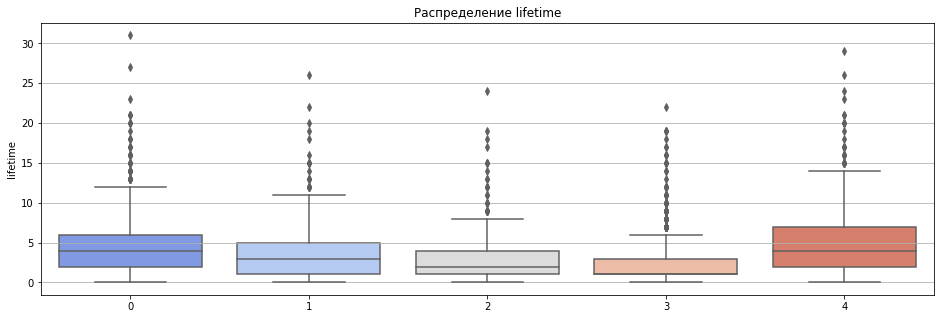

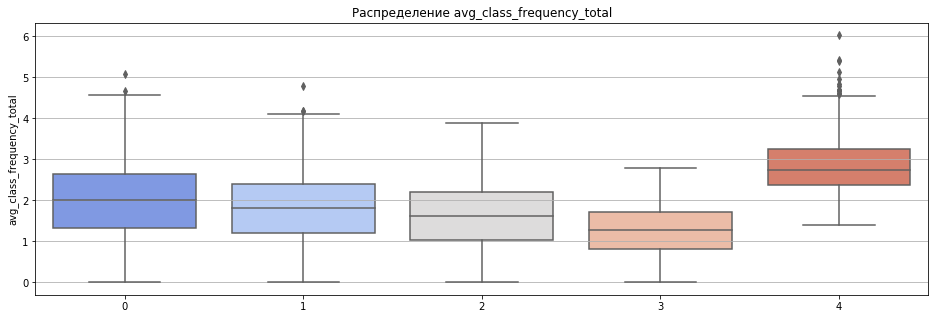

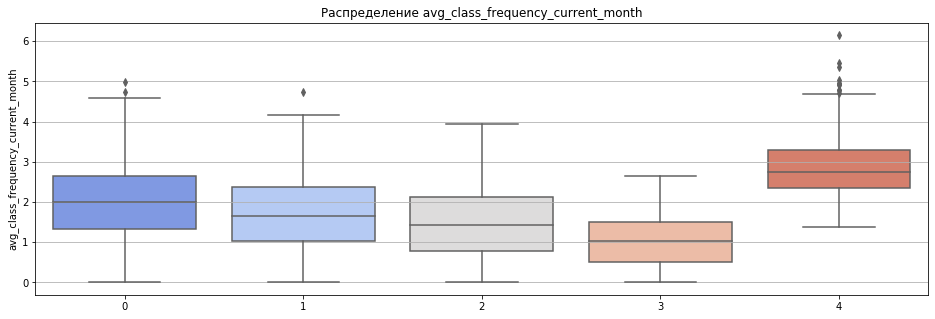

In [20]:
# Построим боксплоты для непрерывных переменных
for column in сontinuous_variable:
    plt.figure(figsize=(16,5))
    plt.grid()
    sns.boxplot(x = 'cluster_km', y = gym_churn[column], data = gym_churn, palette = 'coolwarm')
    plt.title('Распределение ' + column)
    plt.xlabel('')
    plt.show()

Исходя из более детального рассмотрения показателей каждого из кластеров, можем сделать вывод, что наибольший отток клиентов наблюдается в кластере 3 - доля оттока составляет более 50%.  

Довольно сильное влияние на сроки взаимодействия клиента оказывают следующие показатели:  
* удаленность фитнес-центра от дома или работы;  
* как правило, клиент - не сотрудник компании-партнера;  
* редко первоначальная запись осуществляется в рамках акции «Приведи друга»;  
* небольшой срок действия абонемента;  
* низкие расходы на доп. услуги фитнес-центра; 
* самая низкая средняя частота посещений - примерно 1 раз в неделю.

Наименьший показатель потери клиентов наблюдается в кластере - 0. На его долю приходится чуть более 2% оттока и ему присущи следующие особенности:
* самый высокий показатель принадлежности клиентов к компаниям-партнерам;
* самые долгие сроки действия абонемента (около 12 месяцев);
* траты на доп. услуги - одни из самых высоких;
* средние показатели вовлеченности клиентов в акцию "Приведи друга";  
* средние показатели посещения групповых занятий;
* показатель частоты посещения фитнес-центра - один из наиболее высоких (2 раза в неделю).

### Основные выводы и базовые рекомендации по работе с клиентами <a id='5.'></a>

В процессе исследования более детально были изучены и предобработаны исходные данные, а также, найдены определенные зависимости одних показателей от других. Построена модель бинарной классификации клиентов с целевым признаком - факт оттока клиента в следующем месяце, где модель логистической регрессии показала более лучший результат, и на финальном шаге исследования - данные были разделены на кластеры и полученные результаты проанализированы.

По результатам проведенного анализа были выявлены группы клиентов, которые более остальных склонных к оттоку. Для них в первую очередь характерны: минимальный срок действия абонемента, низкая посещаемость спортзала в течение недели, минимальная частота посещения групповых программ, первоначальная запись вне рамок участия в каких-либо акциях и пр.

Для того, чтобы повысить лояльность клиентов к сети фитнес-центров и снизить показатель оттока предлагаю рассмотреть следующие рекомендации:
* изначально стимулировать клиента на покупку абонемента на более продолжительный срок (например, на 6 месяцев) с помощью различных акций и спецпредложений;
* увеличить частоту посещений групповых занятий с помощью предоставления промо-тренировки на платные занятия или с помощью бесплатной тренировки с тренером;
* предоставление специальных условий или возможностей при продлении абонемента.